# Figure S5
The conditional leak model assumed that the time constant of the integration process is reduced if there is any forward/backward motion, which is an arbitrary, hand-picked criterion to replicate data.

But what is it exactly that is affecting the time constant in the data?
- Does it need to be net motion? (i.e., does the whole field need to move in one direction at a time?)
- Alternatively, maybe local motion is enough?
- Does the motion need to be in the forward/backward directions, or can it be sideways?
- Does it even need to be motion? What about just luminance changes?

In [4]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon, binned_statistic
import colorcet as cc
from tqdm import tqdm
from homr_util import *

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
# Find data
data_dir = "./data/figS5/"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 36 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- Down sample data to 20 Hz
- Cut out snippet around each stimulus epoch, sort by epoch type

In [5]:
bin_dt = 1/20 # downsample data to 20 Hz

# again we only analyze fish velocity
all_fvtraces = []

# align binning 0 at the probe onset
time_bin = np.arange(-14,10,bin_dt)
binned_t = (time_bin[1:]+time_bin[:-1])/2

# loop through fish
for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # timestamp
    t_s = exp.stimulus_log['t'].to_numpy()
    # fish velocity
    fv = exp.stimulus_log['PlaidDynamicWaiting_fish_vel'].to_numpy() * exp.stimulus_log['PlaidDynamicWaiting_fish_swimming'].to_numpy() * 30
        
    # prepare lists to store data (5 conditions x 2!! directions)
    fvtraces = [[] for i in range(10)]
    
    # First, make a list of starting time for all epochs
    t_epoch_start = []
    for epoch in slog:
        t_epoch_start.append(epoch['t_stop']-epoch['duration'])
            
    # go through epochs
    for epoch in slog:
                
        # calculate time stamps
        duration = epoch['duration']
        t_end = epoch['t_stop']
        t_start = t_end - duration
        
        # epoch_id
        eid = epoch['epoch_id']
        
        # cut out snippets (trust end more than start)
        this_epoch_ind = np.logical_and(t_s>t_start, t_s<=t_end)
        this_t = t_s[this_epoch_ind]
        this_t = this_t - t_start - 14
        
        # do binning
        binned_fv = binned_statistic(this_t, fv[this_epoch_ind], bins=time_bin)[0]
        
        # saving
        fvtraces[eid].append(binned_fv)
    
    all_fvtraces.append(fvtraces)

100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:06<00:00,  5.43it/s]


In [6]:
# Conversion to numpy array 
all_fvtraces = np.asarray(all_fvtraces)

In [7]:
# average traces over fish and trial
trial_mean_fvtraces = np.nanmean(all_fvtraces, axis=2)
fish_mean_fvtraces = np.mean(trial_mean_fvtraces, axis=0)
fish_sem_fvtraces = np.std(trial_mean_fvtraces, axis=0)/np.sqrt(n_fish)

# average over time
mean_probe_fv = np.nanmean(all_fvtraces[:, :, :, (binned_t>0) * (binned_t<10)], axis=3)

# over trials
fish_mean_probe_fv = np.mean(mean_probe_fv, axis=2)

# directional difference
directional_fv_diff = (fish_mean_probe_fv[:, 5:] - fish_mean_probe_fv[:, :5]) / np.mean(fish_mean_probe_fv, axis=1)[:, None]

# over fish
group_mean_pfv = np.mean(fish_mean_probe_fv, axis=0)
group_sem_pfv = np.std(fish_mean_probe_fv, axis=0) / np.sqrt(n_fish)

## Panels
### Fig. S5B (mean probe swim speed by conditions)

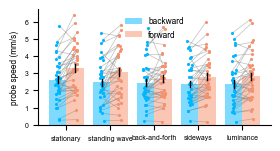

In [15]:
conds = ('stationary', 'standing wave', 'back-and-forth', 'sideways', 'luminance')

fig, ax = plt.subplots(figsize=(3,1.5))
ax.bar(np.arange(5)-0.2, group_mean_pfv[:5], width=0.4, color=cc.cm.CET_D11(0.0), alpha=0.5, label='backward')
ax.bar(np.arange(5)+0.2, group_mean_pfv[5:], width=0.4, color=cc.cm.CET_D11(1.0), alpha=0.5, label='forward')

for i in range(5):
    # individual data
    jitter = (np.random.rand(n_fish)-0.5) * 0.1
    
    ax.plot(np.vstack((jitter+i-0.2, jitter+i+0.2)), fish_mean_probe_fv[:, (i,i+5)].T, color=(0.5,0.5,0.5), alpha=0.5, lw=0.5)
    ax.scatter(jitter+i-0.2, fish_mean_probe_fv[:, i], s=5, color=cc.cm.CET_D11(0.0), zorder=3)
    ax.scatter(jitter+i+0.2, fish_mean_probe_fv[:, i+5], s=5, color=cc.cm.CET_D11(1.0), zorder=3)
    
    # error bar
    ax.plot((i-0.2, i-0.2), (group_mean_pfv[i]-group_sem_pfv[i], group_mean_pfv[i]+group_sem_pfv[i]), 'k-', lw=1, zorder=5)
    ax.plot((i+0.2, i+0.2), (group_mean_pfv[i+5]-group_sem_pfv[i+5], group_mean_pfv[i+5]+group_sem_pfv[i+5]), 'k-', lw=1, zorder=5)
    
ax.set_ylabel('probe speed (mm/s)')
ax.set_xticks(np.arange(5))
ax.set_xticklabels(conds)
toggle_spines(ax,0,1,0,1)

ax.legend()
plt.savefig('./svgs/FigS5B.svg', format='svg')
plt.show()

### Fig. S5C (fractional difference of probe speed by priming directions)

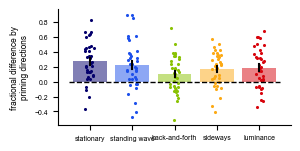

In [17]:
fig, ax = plt.subplots(figsize=(3, 1.5))
p = scatter_bar(directional_fv_diff.T, ax=ax, connect=False, color=cc.cm.CET_R4, condnames=conds) # not connected due to the visibiluty issue
ax.plot((-0.5,4.5),(0,0),'k--')
toggle_spines(ax, 0, 1, 0, 1)
ax.set_ylabel('fractional difference by\npriming directions')
plt.savefig('./svgs/FigS5C.svg', format='svg')
plt.show()

In [19]:
# run stats
for i in range(1,5):
    this_p = wilcoxon(directional_fv_diff[:, 0] - directional_fv_diff[:, i])[1]
    print('Fractional difference stationary vs',conds[i],'p = {:0.2e}'.format(this_p))

Fractional difference stationary vs standing wave p = 2.86e-01
Fractional difference stationary vs back-and-forth p = 2.12e-05
Fractional difference stationary vs sideways p = 1.83e-02
Fractional difference stationary vs luminance p = 1.60e-02
